## Imports & Helpers

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')
from checkmate_imports import *

# global variables 
HUE_ORDER = ['stroma','pred_g2','intermediate_grade','pred_g4']
MIN_SEGMENT_SIZE = 50
GRADE_DIFF_THRESH = 0.35
TUMOR_DIFF_THRESH = 0.35
MIN_TUMOR_SEG_MEAN = 0.70
NODE_DIFF_CUTOFF = invert_rag_weight(GRADE_DIFF_THRESH) 
MIN_TIL_COUNT = 10

# GRADE_TC_CUTOFF = 0.4  # minimum segment mean grade score to consider in TIL processing 
GRADE_TC_CUTOFF = 0.  # minimum segment mean grade score to consider in TIL processing 

print('MODIFYING EARLIER TIL CUTOFFS')
TIL_ISO_CUTOFF = 25 
TIL_HIGH_CUTOFF = 25  # redundant
FRAC_CUTOFF = 0.25
TIL_AREA_CUTOFF = 10

EXCLUSION_RATIO_CUTOFF = 1.5  # margin vs center ratio threshold for "exclusion" call
TILES_PER_MM2 = 0.256**-2

# assume 7x7 minimum case for a square area focus
# going 2 tiles inner would result in a 5x5 inner cube and thus area cutoff of 25
# MIN_CENTER_AREA = 25
MIN_CENTER_AREA = 10  # relaxing from 25 to try to recover possible interesting foci

MODIFYING EARLIER TIL CUTOFFS


### Load saved files 

In [2]:
feature_subset = pd.read_csv('./additional_feature_subset_expanded_postprocessing_with_edgescore_categories.csv', index_col=0)

anno = pd.read_csv('manual_cm025_merged_braunsupp_annotations.csv') 
anno['unique_id'] = 'cm025_' + anno.subjid.astype(str)
paper_desert = anno.loc[anno.ImmunoPhenotype == 'Desert','unique_id'].values
paper_infl = anno.loc[anno.ImmunoPhenotype == 'Infiltrated','unique_id'].values
paper_excl = anno.loc[anno.ImmunoPhenotype == 'Excluded','unique_id'].values
anno = anno.set_index('unique_id')

handpicked_rag_ex = pd.read_csv('./handpicked_rag_ex_ids_ext.csv').iloc[:,1].values

node_descriptions = pd.read_csv('./node_descriptions_with_score_components.csv',index_col=[0])
node_descriptions['merged_labels'] = node_descriptions['merged_labels'].astype(int)

prox_dist_edges = pd.read_csv('./proximal_and_distal_edge_annotations_with_score_components.csv',index_col=0)

scores = pd.read_csv('./slidewise_grade_til_scores.csv', index_col=0)

tilewise_anno = pd.read_csv('./tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset

# load_tile_info = False

# if load_tile_info:
#     tilewise_anno = pd.read_csv('./tilewise_grade_til_annotations.csv', index_col=0) # TIL specific CM025 subset
#     node_descriptions = pd.read_csv('./node_descriptions.csv', index_col=0)

#     edge_info = pd.read_csv('./base_rag_edge_info_annotation.csv', index_col=[0,1,2,3])
#     # restore set objects (stored as string when saved to csv earlier)
#     edge_info['edge_set'] = edge_info.reset_index()[['edge0','edge1']].apply(lambda x: set(x),1).values

#     # read in non-TIL tilewise info 
#     seg_agg = pd.read_csv('./tilewise_grade_nontil_annotations.csv', index_col=0)
    
#     edge_agg_pivot = pd.read_csv('./base_rag_edge_info_annotation_processed.csv', index_col=[0,1,2])
#     edge_class_sum = pd.read_csv('./base_rag_edge_info_annotation_processed_sum.csv', index_col=0)
#     edge_binary = edge_class_sum > 0

In [3]:
from scipy.stats import kstest
from sklearn.mixture import GaussianMixture

nonstroma_tilewise_anno = tilewise_anno.loc[tilewise_anno.meta != 'stroma']

frac_all_above_50 = (tilewise_anno['til_counts'] > 50).groupby('unique_id').mean()
frac_tumor_above_50 = (nonstroma_tilewise_anno['til_counts'] > 50).groupby('unique_id').mean()
feature_subset['frac_tumor_above_50'] = frac_tumor_above_50

gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(frac_tumor_above_50.values.reshape(-1,1))
temp = feature_subset.copy()
gmm_labels = pd.Series(dict(zip(frac_tumor_above_50.index.values, gmm_labels)))
temp['gmm_label'] = gmm_labels

findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.


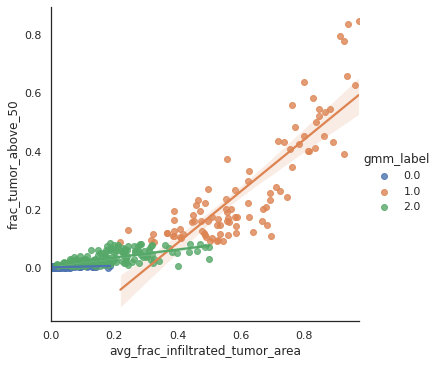

In [4]:
sns.lmplot('avg_frac_infiltrated_tumor_area','frac_tumor_above_50', temp,  hue='gmm_label', sharex=False)

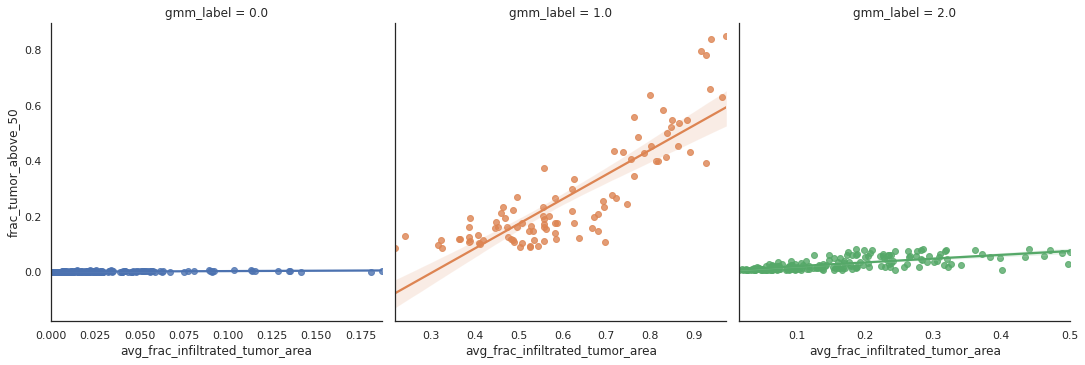

In [5]:
sns.lmplot('avg_frac_infiltrated_tumor_area','frac_tumor_above_50', temp,col='gmm_label', hue='gmm_label', sharex=False)

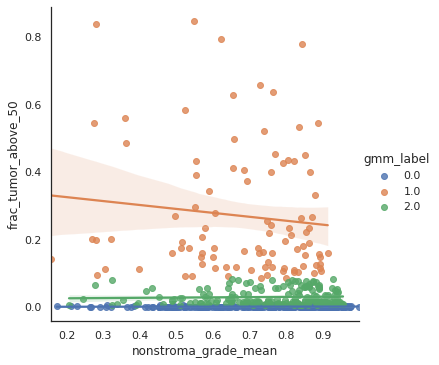

In [6]:
sns.lmplot('nonstroma_grade_mean','frac_tumor_above_50', temp,  hue='gmm_label', sharex=False)

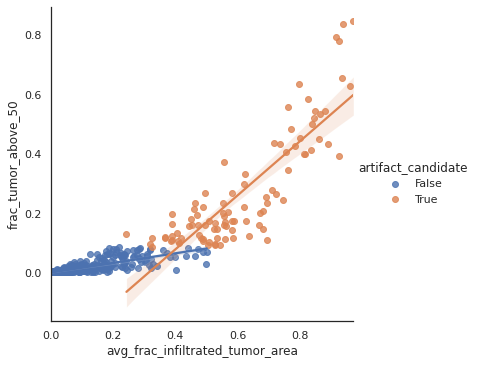

In [7]:
frac_all_above_50 = (tilewise_anno['til_counts'] > 50).groupby('unique_id').mean()
frac_tumor_above_50 = (nonstroma_tilewise_anno['til_counts'] > 50).groupby('unique_id').mean()

gmm_min = 0.086162

cutoff = gmm_min
candidate_artifact_cases = get_indices(frac_tumor_above_50 > cutoff)
candidate_passing_cases = get_indices(frac_tumor_above_50 <= cutoff)

feature_subset.loc[candidate_artifact_cases, 'artifact_candidate'] = True
feature_subset.loc[candidate_passing_cases, 'artifact_candidate'] = False

sns.lmplot('avg_frac_infiltrated_tumor_area','frac_tumor_above_50', feature_subset,  hue='artifact_candidate', sharex=False)

In [8]:
ext_samples = pd.read_csv('../grade_til_inspection_450/20210910_cm025_til_grade_sweep_inspection_samples_450.csv')
t_samples = pd.read_csv('../20210910_cm025_til_grade_sweep_inspection_samples_450_THOMAS_TEMPLATE_filled.csv', index_col=1).iloc[:,1:]
t_samples = ext_samples.set_index('rel_idx').join(t_samples)

t_til_mapper = {
    'high':'high', 'none':'n/a', 'moderate/high':'moderate', 'few':'low', 'moderate':'moderate', 1:'low', 'moderate ':'moderate',
    'lot':'high', 'very few':'low'
}

t_samples['yes_til_thomas'] = t_samples['TIL/noTIL/Too difficult'] == 'til'
t_samples['til_extent_thomas'] = t_samples['Extent of TIL'].map(t_til_mapper)
t_samples['Extent of TIL'] = t_samples['Extent of TIL'].fillna('n/a')
t_samples['til_extent_thomas'] = t_samples['til_extent_thomas'].fillna('n/a')

t_samples['mod_high_infiltration_thomas'] = (t_samples['til_extent_thomas'] == 'moderate') | (t_samples['til_extent_thomas'] == 'high')
t_samples['high_infiltration_thomas'] = t_samples['til_extent_thomas'] == 'high'

t_samples = t_samples.reset_index().set_index(['unique_id','x','y']).join(tilewise_anno.set_index(['x','y'],append=True)[['smoothed_prob_tumor','smoothed_prob_g4_not_g2','til_counts']])

In [9]:
TIL_ISO_CUTOFF

25

In [10]:
t_samples['hard_case'] = t_samples['TIL/noTIL/Too difficult'].isin(['hard','hard/til'])
t_samples['pred_modhigh'] = t_samples['til_counts'] > TIL_ISO_CUTOFF
t_samples['high_grade_subset'] = t_samples['smoothed_prob_g4_not_g2'] >= 0.8
t_samples['correct_pred_modhigh'] = t_samples['mod_high_infiltration_thomas'] == t_samples['pred_modhigh'] 

In [11]:
t_samples['correct_pred_modhigh'].mean()

0.7377777777777778

In [12]:
t_samples.groupby(['mod_high_infiltration_thomas','high_grade_subset'])['correct_pred_modhigh'].mean()

mod_high_infiltration_thomas  high_grade_subset
False                         False                0.691892
                              True                 0.828571
True                          False                0.658537
                              True                 0.726190
Name: correct_pred_modhigh, dtype: float64

In [13]:
t_samples.groupby(['high_grade_subset','mod_high_infiltration_thomas'])['correct_pred_modhigh'].mean()

high_grade_subset  mod_high_infiltration_thomas
False              False                           0.691892
                   True                            0.658537
True               False                           0.828571
                   True                            0.726190
Name: correct_pred_modhigh, dtype: float64

In [14]:
t_samples.groupby(['high_grade_subset','mod_high_infiltration_thomas','hard_case'])['correct_pred_modhigh'].aggregate(['count','mean'])

count      mean
high_grade_subset mod_high_infiltration_thomas hard_case                 
False             False                        False        158  0.727848
                                               True          27  0.481481
                  True                         False         41  0.658537
True              False                        False        114  0.877193
                                               True          26  0.615385
                  True                         False         83  0.734940
                                               True           1  0.000000

### Generalize to multiple cutoff checks

In [15]:
# del feature_subset['frac_tumor_above_50']

In [16]:
meta_check = {cutoff:(nonstroma_tilewise_anno['til_counts'] > cutoff).groupby('unique_id').mean() for cutoff in np.arange(5,60,5)}

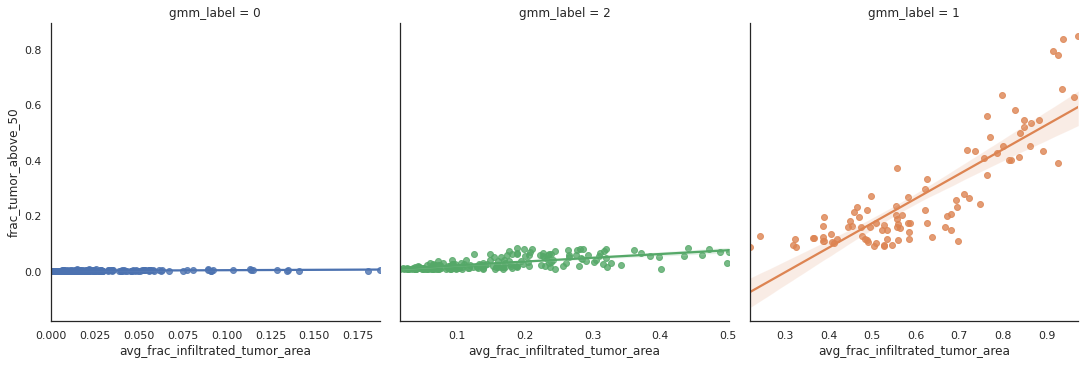

In [17]:
cutoff = 50
data = meta_check[cutoff]
data.name = f'frac_tumor_above_{cutoff}'

gmm = GaussianMixture(n_components=3)
gmm_labels = gmm.fit_predict(data.values.reshape(-1,1))
temp = merge_nonoverlapping(feature_subset.copy(), data.reset_index())
gmm_labels = pd.Series(dict(zip(data.index.values, gmm_labels)))
temp['gmm_label'] = gmm_labels

sns.lmplot('avg_frac_infiltrated_tumor_area',f'frac_tumor_above_{cutoff}', temp,  hue='gmm_label', col='gmm_label', col_order=pd.Series(gmm.means_.reshape(-1)).sort_values().index.values,sharex=False)

In [18]:
def get_fraction_infiltrated(df, col='til_counts', cutoff=25, seg_col='merged_labels'):
    """
    Return fraction of df[col] above cutoff (ie, % infiltration in a segment)
    """
    
    return df[col].apply(lambda x: (x > cutoff)).mean()

In [19]:
gmm_min = 0.086162
artifact_thresh = 50

cutoff = gmm_min
candidate_artifact_cases = get_indices(meta_check[artifact_thresh] > cutoff)
candidate_passing_cases = get_indices(meta_check[artifact_thresh] <= cutoff)

feature_subset.loc[candidate_artifact_cases, 'artifact_candidate'] = True
feature_subset.loc[candidate_passing_cases, 'artifact_candidate'] = False

In [20]:
jump

NameError: name 'jump' is not defined

In [ ]:
feature_subset['artifact_candidate'].dropna().to_csv('./artifact_candidates_from_comparing_til_distributions_NB.csv')

In [ ]:
segwise_meta = {cutoff:nonstroma_tilewise_anno.groupby(['unique_id','merged_labels']).til_counts.apply(lambda x: (x>cutoff).aggregate(['count','sum','mean'])) for cutoff in np.arange(5,60,5)}

segwise_meta_agg = pd.DataFrame()

for k,v in segwise_meta.items():
    df = v.copy()
    df.index = df.index.set_names(['unique_id', 'merged_labels', 'stat'])
    df = df.reset_index().pivot_table(index=['unique_id','merged_labels'], columns='stat', values='til_counts')
    df['infiltration_cutoff'] = k 
    
    segwise_meta_agg = segwise_meta_agg.append(df)

segwise_meta_agg = segwise_meta_agg.loc[segwise_meta_agg['count'] >= MIN_SEGMENT_SIZE]

In [ ]:
flag = meta_check[50] > cutoff
flag.name = 'artifact_candidate'

df = segwise_meta_agg.join(flag)

sns.catplot(x='infiltration_cutoff', hue='artifact_candidate', y='sum', data=df.groupby(['unique_id','infiltration_cutoff']).median().reset_index(), kind='bar')

In [ ]:
set_rc(15,10,2)
aggr_stat = 'mean'
min_presence = 0.05

plot_temp = df.groupby(['unique_id','infiltration_cutoff'])[aggr_stat].apply(lambda x: (x >= min_presence).mean()).reset_index()
plot_temp = plot_temp.set_index('unique_id').join(flag)
sns.catplot(x='infiltration_cutoff', hue='artifact_candidate', y=aggr_stat, data=plot_temp, kind='bar', height=10)
plt.ylabel('Fraction')
plt.xlabel('Infiltration Cutoff')
plt.title(f'Fraction of Segments with at least {int(min_presence*100)}% Infiltration'.title())
plt.savefig(f'./main_figs/Fraction of Segments with at least {int(min_presence*100)}% Infiltration.png')

In [ ]:
set_rc(15,10,2)
aggr_stat = 'mean'
min_presence = 0.1

plot_temp = df.groupby(['unique_id','infiltration_cutoff'])[aggr_stat].apply(lambda x: (x >= min_presence).mean()).reset_index()
plot_temp = plot_temp.set_index('unique_id').join(flag)
sns.catplot(x='infiltration_cutoff', hue='artifact_candidate', y=aggr_stat, data=plot_temp, kind='bar', height=10)
plt.ylabel('Fraction')
plt.xlabel('Infiltration Cutoff')
plt.title(f'Fraction of Segments with at least {int(min_presence*100)}% Infiltration'.title())
plt.savefig(f'./main_figs/Fraction of Segments with at least {int(min_presence*100)}% Infiltration.png')

In [ ]:
df.to_csv('./segmentwise_cutoff_aggregation_comparing_til_distributions_NB.csv')

In [ ]:
tumor_segment_mean = nonstroma_tilewise_anno.groupby(['unique_id','merged_labels']).mean()

In [ ]:
df = df.join(tumor_segment_mean[['smoothed_prob_tumor','smoothed_prob_g4_not_g2']])

In [ ]:
diff_artifact_flag = df.loc[df['infiltration_cutoff'] == 50].groupby('unique_id')['mean'].apply(lambda x: np.any(x > 0.05))

In [ ]:
diff_artifact_flag.value_counts()

In [ ]:
diff_artifact_flag.name = 'artifact_candidate_alt'

In [ ]:
diff_artifact_flag.dropna().to_csv('./artifact_candidates_stricter_from_comparing_til_distributions_NB.csv')

---

In [ ]:
default_artifacts = pd.read_csv('./artifact_candidates_from_comparing_til_distributions_NB.csv',index_col=0)

In [ ]:
t_samples = t_samples.join(default_artifacts)

In [ ]:
t_samples = t_samples.join(diff_artifact_flag)

In [ ]:
t_samples['pred_infiltrated'] = t_samples['til_counts'] > TIL_ISO_CUTOFF

# inf_col = 'yes_til_thomas'
inf_col = 'mod_high_infiltration_thomas'

t_samples.loc[t_samples['pred_infiltrated'] & ~t_samples[inf_col], 'pred_type'] = 'fp'
t_samples.loc[t_samples['pred_infiltrated'] & t_samples[inf_col], 'pred_type'] = 'tp'

t_samples.loc[~t_samples['pred_infiltrated'] & t_samples[inf_col], 'pred_type'] = 'fn'
t_samples.loc[~t_samples['pred_infiltrated'] & ~t_samples[inf_col], 'pred_type'] = 'tn'

t_samples['correct_pred'] = t_samples['pred_infiltrated'] == t_samples[inf_col]
t_samples['false_infiltration_call'] = t_samples['pred_infiltrated'] & ~t_samples[inf_col] 

In [ ]:
t_samples['correct_pred'].mean()

In [ ]:
def calc_rate(df, rate_type='fpr'):

    if rate_type == 'tpr':
        return df['tp']/(df['tp']+df['fn'])
    
    if rate_type == 'tnr':
        return df['tn']/(df['tn']+df['fp'])

    if rate_type == 'fpr':
        return df['fp']/(df['fp']+df['tn'])
    
    if rate_type == 'fnr':
        return df['fn']/(df['fn']+df['tp'])

    

In [ ]:
calc_rate(t_samples.value_counts(['pred_type']),'fpr')

In [ ]:
calc_rate(t_samples.value_counts(['pred_type']),'fnr')

In [ ]:
# from til_grade_cutoff_selection_and_paper_immunophenotype_comparison
# t_samples_filtered = t_samples.loc[~t_samples['artifact_candidate_alt']]
t_samples_filtered = t_samples.loc[~t_samples['hard_case']]

set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0, 0.125, 0.25, 1/3, 2/3]

for f1_avg_type in ['macro','micro']:
    results = []

    for til_thresh in til_thresholds:
        for q in quantiles:
            grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            f1 = f1_score(subset['yes_til_thomas'], subset['infiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset['yes_til_thomas']).mean()
            results.append((til_thresh, q, grade_thresh, f1, acc))

    results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc'])

    for q, df in results.groupby(['grade_quantile']):
        cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
        plt.plot(df['til_thresh'], df['f1'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
    ax = plt.gca()
    plt.ylabel(f'F1 ({f1_avg_type.title()})')
    for cutoff in [5,10,30]:
        plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    plt.ylim(0,1)
    plt.xlabel('TIL Cutoff')
    plt.legend()
#     plt.savefig(f'./main_figs/til_grade_review__none_vs_any_F1_{f1_avg_type}.png')
    plt.show()

for q, df in results.groupby(['grade_quantile']):
    cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    plt.plot(df['til_thresh'], df['acc'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
ax = plt.gca()
for cutoff in [5,10,30]:
    plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    
plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0,1)
plt.xlabel('TIL Cutoff')
# plt.savefig('./main_figs/til_grade_review__none_vs_any_ACCURACY.png')
plt.show()

In [ ]:
# from til_grade_cutoff_selection_and_paper_immunophenotype_comparison
inf_col = 'mod_high_infiltration_thomas'
# t_samples_filtered = t_samples.loc[~t_samples['artifact_candidate_alt']]
t_samples_filtered = t_samples.loc[~t_samples['hard_case']]

set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0, 0.125, 0.25, 1/3, 2/3]

for f1_avg_type in ['macro','micro']:
    results = []

    for til_thresh in til_thresholds:
        for q in quantiles:
            grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            f1 = f1_score(subset[inf_col], subset['infiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset[inf_col]).mean()
            results.append((til_thresh, q, grade_thresh, f1, acc))

    results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc'])

    for q, df in results.groupby(['grade_quantile']):
        cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
        plt.plot(df['til_thresh'], df['f1'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
    ax = plt.gca()
    plt.ylabel(f'F1 ({f1_avg_type.title()})')
    for cutoff in [5,10,25,30]:
        plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    plt.ylim(0,1)
    plt.xlabel('TIL Cutoff')
    plt.legend()
#     plt.savefig(f'./main_figs/til_grade_review__none_vs_any_F1_{f1_avg_type}.png')
    plt.show()

for q, df in results.groupby(['grade_quantile']):
    cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    plt.plot(df['til_thresh'], df['acc'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
ax = plt.gca()
for cutoff in [5,10,25, 30]:
    plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    
plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0,1)
plt.xlabel('TIL Cutoff')
# plt.savefig('./main_figs/til_grade_review__none_vs_any_ACCURACY.png')
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

In [ ]:
set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0, 0.125, 0.25, 1/3, 2/3]
# f1_avg_type='macro'

fig, axes = plt.subplots(1,2, figsize=(20,8))

results = []
for q in quantiles:
    grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset['mod_high_infiltration_thomas'], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset['mod_high_infiltration_thomas'], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[0])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[0].set_title('Unfiltered')

results = []
for q in quantiles:
    grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset['mod_high_infiltration_thomas'], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset['mod_high_infiltration_thomas'], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[1])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[1].set_title('Strict Artifact Filtered')
plt.tight_layout()
plt.show()

In [ ]:
t_samples_filtered = t_samples.loc[~t_samples['artifact_candidate_alt']]
t_samples_filtered_default = t_samples.loc[~t_samples['artifact_candidate']]

inf_col = 'yes_til_thomas'
set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0, 0.125, 0.25, 1/3, 2/3]
# f1_avg_type='macro'

fig, axes = plt.subplots(1,3, figsize=(24,8))

results = []
for q in quantiles:
    grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[0])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[0].set_title('Unfiltered')

results = []
for q in quantiles:
    grade_thresh = t_samples_filtered_default['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples_filtered_default.loc[t_samples_filtered_default['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[1])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[1].set_title('Default Artifact Filtered')

results = []
for q in quantiles:
    grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[2])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[2].set_title('Strict Artifact Filtered')
plt.tight_layout()
plt.show()

In [ ]:
t_samples_filtered = t_samples.loc[~t_samples['artifact_candidate_alt']]
t_samples_filtered_default = t_samples.loc[~t_samples['artifact_candidate']]

inf_col = 'mod_high_infiltration_thomas'
set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0, 0.125, 0.25, 1/3, 2/3]
# f1_avg_type='macro'

fig, axes = plt.subplots(1,3, figsize=(24,8))

results = []
for q in quantiles:
    grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[0])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[0].set_title('Unfiltered')

results = []
for q in quantiles:
    grade_thresh = t_samples_filtered_default['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples_filtered_default.loc[t_samples_filtered_default['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[1])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[1].set_title('Default Artifact Filtered')

results = []
for q in quantiles:
    grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
    auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
    fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
    RocCurveDisplay(fpr, tpr, roc_auc=auroc, estimator_name=f'Grade Q({q:.2f})').plot(ax=axes[2])
    results.append((q, grade_thresh, auroc))

results = pd.DataFrame(np.stack(results), columns=['grade_quantile', 'grade_thresh','auroc'])
axes[2].set_title('Strict Artifact Filtered')
plt.tight_layout()
plt.show()

In [ ]:
t_samples

In [ ]:
inf_col = 'mod_high_infiltration_thomas'

subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]
subset = subset.loc[~subset['hard_case']]
auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])

In [ ]:
thresh_range = range(10,50)
results = []
scores = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.8)
    scores = [f1_score(samples[inf_col], samples['til_counts'] > cutoff, average=f1_avg_type) for cutoff in thresh_range]
    out = np.argmax(scores)
    max_score = scores[out]
    results.append(thresh_range[out])
    scores.append(max_score)

In [ ]:
plt.hist(results,bins=15)

In [ ]:
plt.hist(scores,bins=15)

In [ ]:
np.median(results)

In [ ]:
results = []
scores = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.5)
    score = roc_auc_score(samples[inf_col], samples['til_counts'])
    fpr, tpr, thresholds = roc_curve(samples[inf_col], samples['til_counts'])
    out = thresholds[np.argmin(((1 - tpr)**2 + fpr**2)**0.5)]

    results.append(out)
    scores.append(score)

In [ ]:
np.median(results)

In [ ]:
plt.hist(results,bins=15)

In [ ]:
plt.hist(scores,bins=15)

---

In [ ]:
resume

In [35]:
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay

In [36]:
t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]['hard_case'].value_counts()

False    197
True      27
Name: hard_case, dtype: int64

In [37]:
inf_col = 'yes_til_thomas'
f1_avg_type = 'macro'

subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]
print('including hard cases')

auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])
auroc

including hard cases


0.626525054466231

In [38]:
inf_col = 'yes_til_thomas'
f1_avg_type = 'macro'

subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]
subset = subset.loc[~subset['hard_case']]

auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])

In [39]:
auroc

0.6915032679738562

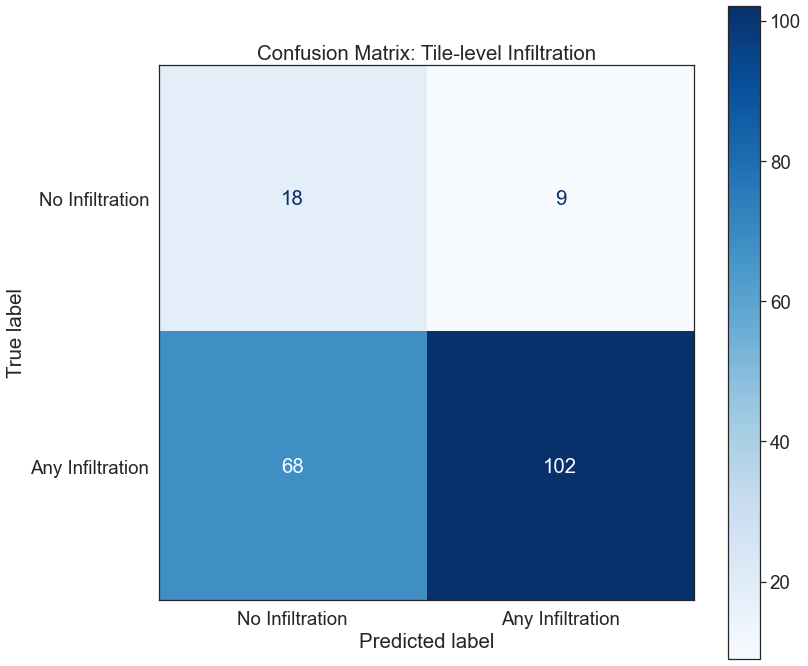

In [40]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

subset['pred'] = (subset['til_counts'] > 14).astype(int)

sns.set(palette='colorblind', style='white', font_scale=1.7)
disp = ConfusionMatrixDisplay(
    confusion_matrix(subset['yes_til_thomas'].astype(int), subset['pred']), display_labels=['No Infiltration','Any Infiltration'],
)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix: Tile-level Infiltration')
plt.savefig('./20230401_til_confusion_matrix', bbox_inches='tight')

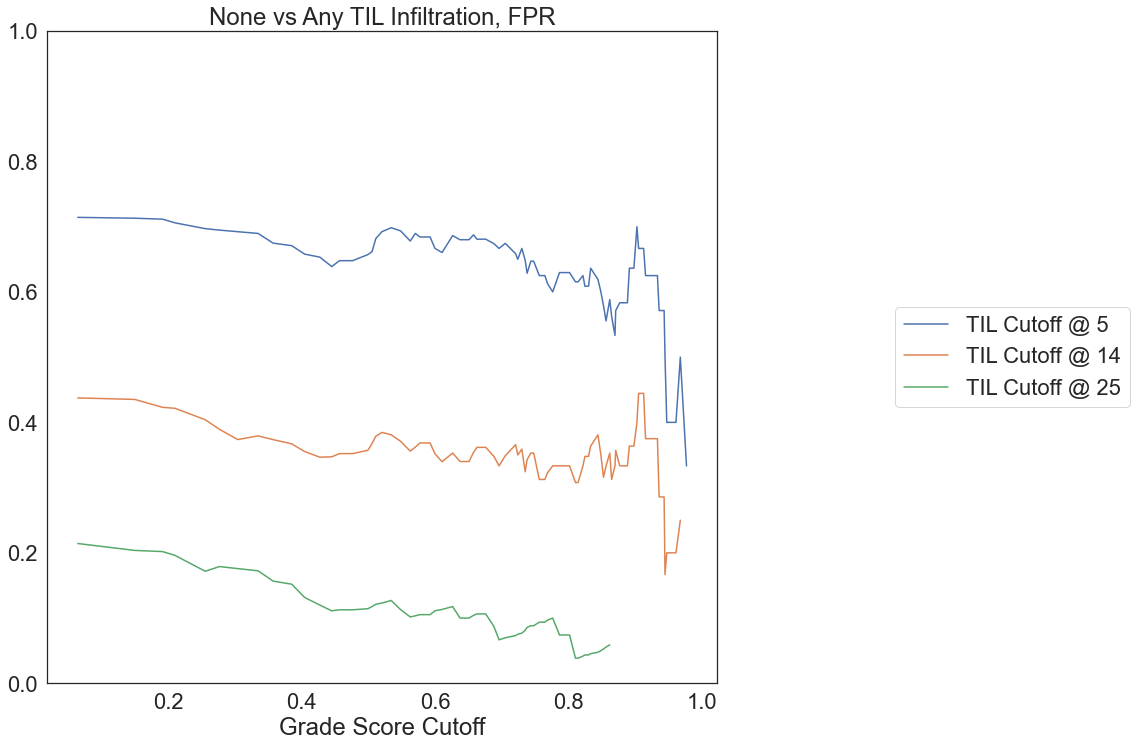

In [41]:
set_rc(12,12,2)
sns.set_style('white')
label_col = 'yes_til_thomas'
quantiles = np.linspace(0, 1, 100)

# f1_avg_type='macro'

for f1_avg_type in ['macro']:
    for til_thresh in [5,14,25]:

        results = []
        for q in quantiles:
            grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            subset['noninfiltrated'] = ~subset['infiltrated']
            subset['flipped_label']= 1-subset[label_col]
            
            subset = subset.loc[~subset['hard_case']]
#             subset = subset.sample(frac=0.8)

            f1 = f1_score(subset['flipped_label'], subset['noninfiltrated'], average=f1_avg_type)
#             f1 = f1_score(subset[label_col], subset['infiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset[label_col]).mean()
            try:
                fpr = subset.value_counts([label_col,'infiltrated']).groupby(label_col).apply(lambda x: x/x.sum()).loc[(False, True)]
            except:
                fpr = np.nan

            results.append((til_thresh, q, grade_thresh, f1, acc, fpr))

        results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc','fpr'])

        plt.plot(results['grade_thresh'], results['fpr'], label=f'TIL Cutoff @ {til_thresh}')
#         plt.ylabel(f'F1 ({f1_avg_type.title()})')
        plt.xlabel('Grade Score Cutoff')

#     for q in [0.125, 0.25, 0.5, 0.75]:
#         grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
#         plt.axvline(grade_thresh, label=f'Q({q:.2f})', color = next(ax._get_lines.prop_cycler)['color'])
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.ylim(0,1)
    plt.title(f'None vs Any TIL Infiltration, FPR')
#     plt.savefig(f'./main_figs/til_grade_review__none_vs_any__FPR_(noninfiltrated)_grade_xaxis.png', bbox_inches='tight')
    plt.show()


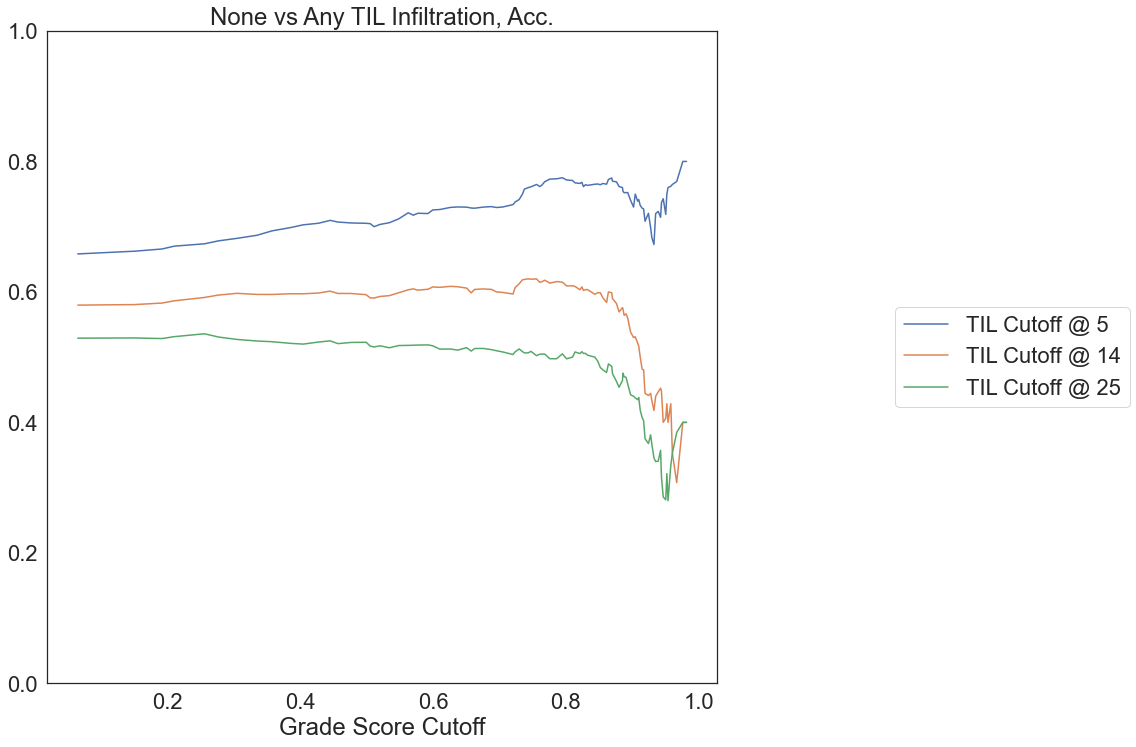

In [42]:
set_rc(12,12,2)
sns.set_style('white')
label_col = 'yes_til_thomas'
quantiles = np.linspace(0, 1, 100)

# f1_avg_type='macro'

for f1_avg_type in ['macro']:
    for til_thresh in [5,14,25]:

        results = []
        for q in quantiles:
            grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            subset['noninfiltrated'] = ~subset['infiltrated']
            subset['flipped_label']= 1-subset[label_col]
            
            subset = subset.loc[~subset['hard_case']]
#             subset = subset.sample(frac=0.8)

            f1 = f1_score(subset['flipped_label'], subset['noninfiltrated'], average=f1_avg_type)
#             f1 = f1_score(subset[label_col], subset['infiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset[label_col]).mean()
            try:
                fpr = subset.value_counts([label_col,'infiltrated']).groupby(label_col).apply(lambda x: x/x.sum()).loc[(False, True)]
            except:
                fpr = np.nan

            results.append((til_thresh, q, grade_thresh, f1, acc, fpr))

        results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc','fpr'])

        plt.plot(results['grade_thresh'], results['acc'], label=f'TIL Cutoff @ {til_thresh}')
#         plt.ylabel(f'F1 ({f1_avg_type.title()})')
        plt.xlabel('Grade Score Cutoff')

#     for q in [0.125, 0.25, 0.5, 0.75]:
#         grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
#         plt.axvline(grade_thresh, label=f'Q({q:.2f})', color = next(ax._get_lines.prop_cycler)['color'])
    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.ylim(0,1)
    plt.title(f'None vs Any TIL Infiltration, Acc.')
#     plt.savefig(f'./main_figs/til_grade_review__none_vs_any__FPR_(noninfiltrated)_grade_xaxis.png', bbox_inches='tight')
    plt.show()


No handles with labels found to put in legend.


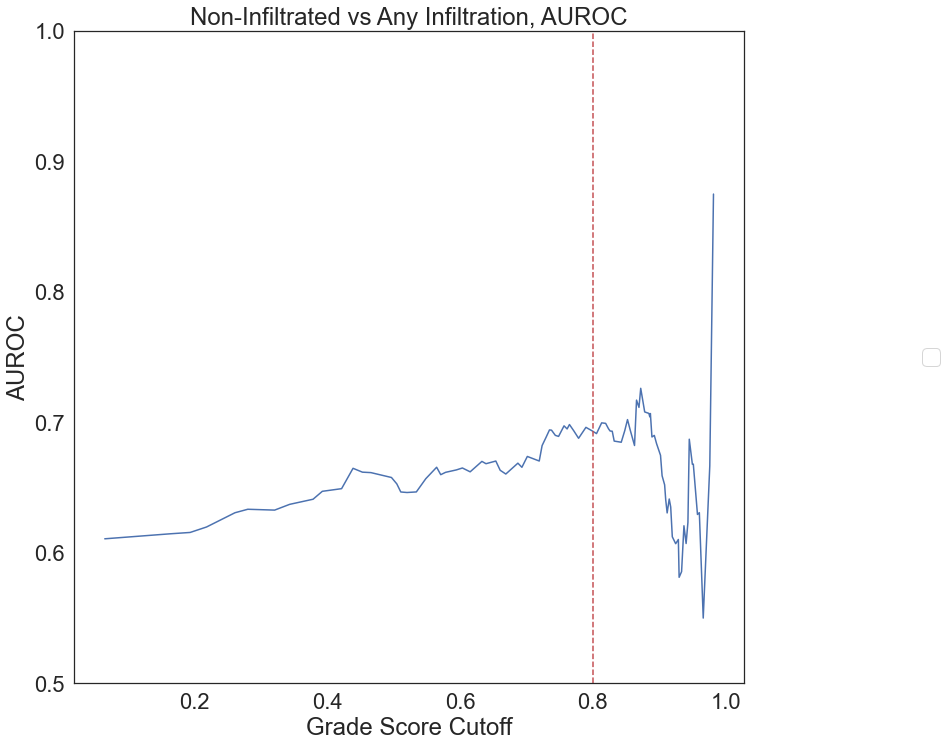

In [43]:
set_rc(12,12,2)
sns.set_style('white')
label_col = 'yes_til_thomas'
quantiles = np.linspace(0, 1, 95)



results = []
for q in quantiles:
    grade_thresh = t_samples['smoothed_prob_g4_not_g2'].quantile(q)
    subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] > grade_thresh]
    subset = subset.loc[~subset['hard_case']]

    try:
        score = roc_auc_score(subset[label_col], subset['til_counts'])
        results.append((til_thresh, q, grade_thresh, score))
    except:
        pass
results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','auroc'])

plt.plot(results['grade_thresh'], results['auroc'])
plt.xlabel('Grade Score Cutoff')

plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylim(0.5,1)
plt.title(f'Non-Infiltrated vs Any Infiltration, AUROC')
plt.axvline(0.8, c='r', ls='--')
plt.ylabel('AUROC')
plt.savefig('./20230401_grade_cutoff_vs_auroc.png', bbox_inches='tight')
plt.show()


In [44]:
thresh_range = range(0,25)
results = []
scores = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.8)
    scores = [f1_score(samples[inf_col], samples['til_counts'] > cutoff, average=f1_avg_type) for cutoff in thresh_range]
    out = np.argmax(scores)
    max_score = scores[out]
    results.append(thresh_range[out])
    scores.append(max_score)

In [45]:
scores

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.]),
 array([-0.5       , -0.43333333, -0.36666667, -0.3       , -0.23333333,
        -0.16666667, -0.1       , -0.03333333,  0.03333333,  0.1       ,
         0.16666667,  0.23333333,  0.3       ,  0.36666667,  0.43333333,
         0.5       ]),
 <BarContainer object of 15 artists>)

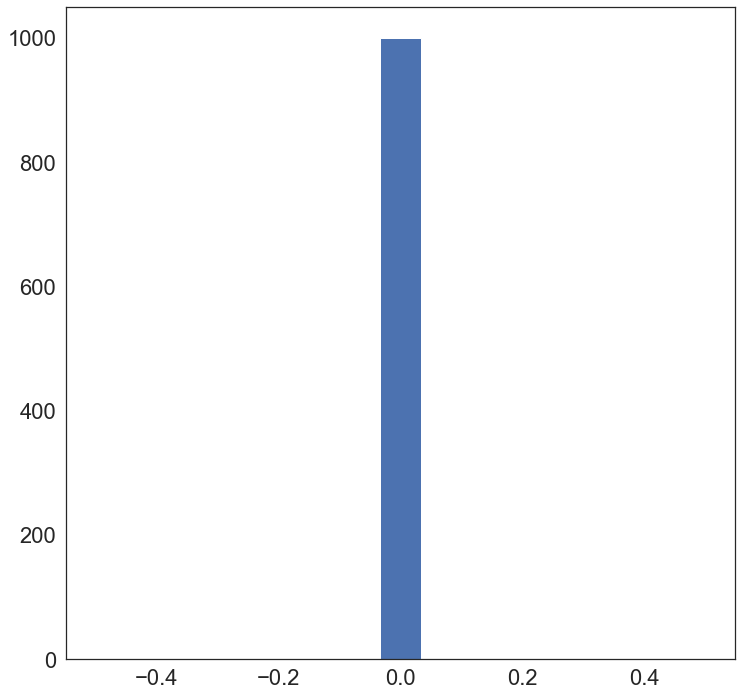

In [46]:
plt.hist(results,bins=15)

In [49]:
subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]
subset = subset.loc[~subset['hard_case']]

In [50]:
results = []
scores = []
for trial in range(int(1e4)):
    samples = subset.sample(frac=0.8)
#     samples = subset.sample(frac=0.5)
    score = roc_auc_score(samples[inf_col], samples['til_counts'])
    fpr, tpr, thresholds = roc_curve(samples[inf_col], samples['til_counts'])
    out = thresholds[np.argmin(((1 - tpr)**2 + fpr**2)**0.5)]

    results.append(out)
    scores.append(score)

In [51]:
(samples[inf_col] ==  (samples['til_counts']>14)).value_counts()

True     93
False    65
dtype: int64

In [52]:
samples = subset.sample(frac=0.8)


samples['correct_pred'] = samples[inf_col] == (samples['til_counts']>14)
print(samples['correct_pred'].mean())
print(samples.groupby(inf_col)['correct_pred'].mean())

0.6455696202531646
yes_til_thomas
False    0.800000
True     0.623188
Name: correct_pred, dtype: float64


In [53]:
samples = subset.sample(frac=0.8)


samples['correct_pred'] = samples[inf_col] == (samples['til_counts']>14)
print(samples['correct_pred'].mean())
print(samples.groupby(inf_col)['correct_pred'].mean())

0.5886075949367089
yes_til_thomas
False    0.631579
True     0.582734
Name: correct_pred, dtype: float64


In [54]:
score

0.6652173913043479

In [55]:
np.median(results)

14.0

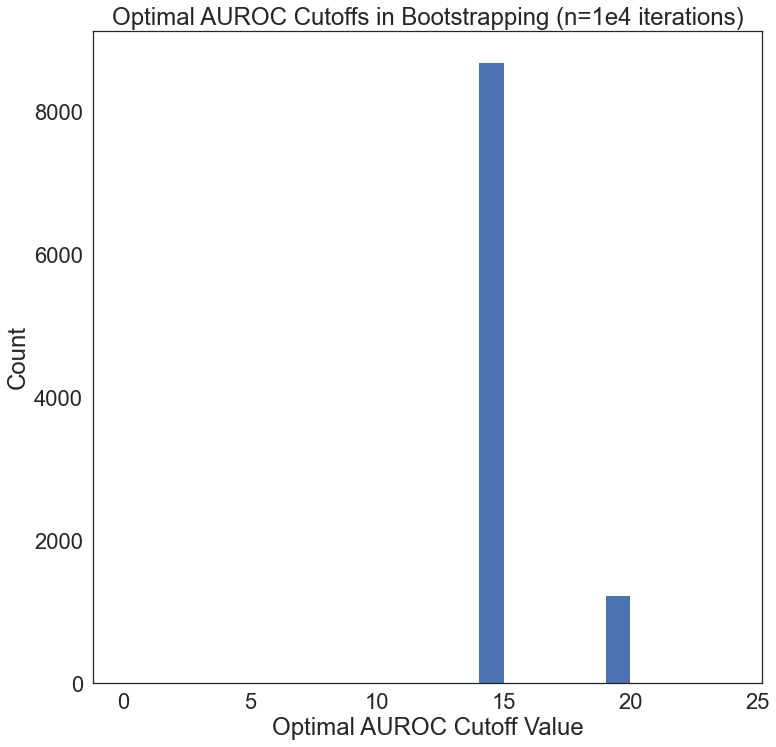

In [56]:
plt.hist(results, bins=range(25))
plt.xlabel('Optimal AUROC Cutoff Value')
plt.ylabel('Count')
plt.title('Optimal AUROC Cutoffs in Bootstrapping (n=1e4 iterations)')
plt.savefig('./20230401_bootstrapping_cutoff_hist.png', bbox_inches='tight')
plt.show()

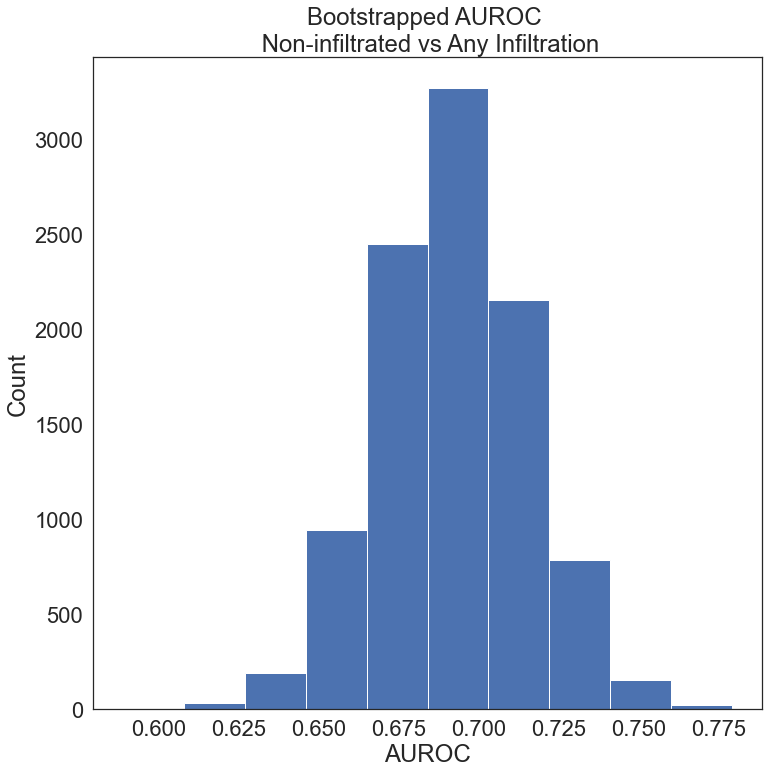

In [57]:
plt.hist(scores)
plt.title('Bootstrapped AUROC \n Non-infiltrated vs Any Infiltration')
plt.xlabel('AUROC')
plt.ylabel('Count')
plt.savefig('./20230401_bootstrapping_auroc_values_hist.png', bbox_inches='tight')
plt.show()

In [58]:
pd.Series(scores).describe()

count    10000.000000
mean         0.691929
std          0.023111
min          0.588889
25%          0.676630
50%          0.691783
75%          0.707308
max          0.778986
dtype: float64

In [59]:
end

NameError: name 'end' is not defined

In [ ]:
f1_results = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.8)
    f1_result = f1_score(samples[inf_col], samples['til_counts'] > 14, average=f1_avg_type)
    f1_results.append(f1_result)

In [ ]:
plt.hist(f1_results)

---

In [ ]:
inf_col = 'high_infiltration_thomas'
f1_avg_type = 'macro'

subset = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]
subset = subset.loc[~subset['hard_case']]

auroc = roc_auc_score(subset[inf_col], subset['til_counts'])
fpr, tpr, thresholds = roc_curve(subset[inf_col], subset['til_counts'])

In [ ]:
auroc

In [ ]:
subset[inf_col].value_counts()

In [ ]:
thresh_range = range(10,50)
results = []
scores = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.8)
    scores = [f1_score(samples[inf_col], samples['til_counts'] > cutoff, average=f1_avg_type) for cutoff in thresh_range]
    out = np.argmax(scores)
    max_score = scores[out]
    results.append(thresh_range[out])
    scores.append(max_score)

In [ ]:
plt.hist(results,bins=15)

In [ ]:
results = []
scores = []
for trial in range(int(1e4)):
    samples = subset.sample(frac=0.6)
#     samples = subset.sample(frac=0.5)
    score = roc_auc_score(samples[inf_col], samples['til_counts'])
    fpr, tpr, thresholds = roc_curve(samples[inf_col], samples['til_counts'])
    out = thresholds[np.argmin(((1 - tpr)**2 + fpr**2)**0.5)]

    results.append(out)
    scores.append(score)

In [ ]:
np.median(results)

In [ ]:
plt.hist(results)

In [ ]:
len(scores)

In [ ]:
plt.hist(scores)

In [ ]:
t_samples.loc[t_samples['high_grade_subset']].groupby(['hard_case','til_extent_thomas'])['til_counts'].describe()

In [ ]:
t_samples.loc[t_samples['high_grade_subset'] & (t_samples['til_extent_thomas'] == 'n/a'),['smoothed_prob_g4_not_g2','hard_case','rel_idx','til_counts']].sort_values('til_counts').tail(10)

In [ ]:
t_samples.loc[t_samples['high_grade_subset'] & (t_samples['til_extent_thomas'] == 'low'),['smoothed_prob_g4_not_g2','hard_case','rel_idx','til_counts']].sort_values('til_counts').tail(10)

In [ ]:
t_samples

In [ ]:
sns.catplot(x='til_extent_thomas', y='til_counts', data=t_samples.loc[t_samples['high_grade_subset']], kind='boxen', order=['n/a','low','moderate','high'])

In [ ]:
sns.catplot(x='til_extent_thomas', y='til_counts', data=t_samples.loc[t_samples['high_grade_subset']], kind='boxen', order=['n/a','low','moderate','high'], col='hard_case')

In [ ]:
t_samples.loc[t_samples['high_grade_subset'] & (t_samples['til_extent_thomas'] == 'low')].til_counts.hist()

In [ ]:
results = []
scores = []
for trial in range(int(1e3)):
    samples = subset.sample(frac=0.5)
    score = roc_auc_score(samples[inf_col], samples['til_counts'])
    fpr, tpr, thresholds = roc_curve(samples[inf_col], samples['til_counts'])
    out = thresholds[np.argmin(((1 - tpr)**2 + fpr**2)**0.5)]

    results.append(out)
    scores.append(score)

In [ ]:
np.median(results)

In [ ]:
plt.hist(results)

In [ ]:
t_samples

In [ ]:
t_samples_filtered = t_samples.loc[t_samples['smoothed_prob_g4_not_g2'] >= 0.8]

set_rc(12,12,2)
sns.set_style('white')
til_thresholds = np.linspace(0, 100, 100)
quantiles = [0]

for f1_avg_type in ['macro','micro']:
    results = []

    for til_thresh in til_thresholds:
        for q in quantiles:
            grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            f1 = f1_score(subset['yes_til_thomas'], subset['infiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset['yes_til_thomas']).mean()
            results.append((til_thresh, q, grade_thresh, f1, acc))

    results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc'])

    for q, df in results.groupby(['grade_quantile']):
        cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
        plt.plot(df['til_thresh'], df['f1'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
    ax = plt.gca()
    plt.ylabel(f'F1 ({f1_avg_type.title()})')
    for cutoff in [5,10,30]:
        plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    plt.ylim(0,1)
    plt.xlabel('TIL Cutoff')
    plt.legend()
#     plt.savefig(f'./main_figs/til_grade_review__none_vs_any_F1_{f1_avg_type}.png')
    plt.show()

for q, df in results.groupby(['grade_quantile']):
    cutoff = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
    plt.plot(df['til_thresh'], df['acc'], label=f'Grade Quantile {q :.2f} = {cutoff :.2f}')
ax = plt.gca()
for cutoff in [5,10,30]:
    plt.axvline(cutoff, label=f'TIL Cutoff @ {cutoff}', color = next(ax._get_lines.prop_cycler)['color'])
    
plt.ylabel('Accuracy')

plt.legend()
plt.ylim(0,1)
plt.xlabel('TIL Cutoff')
# plt.savefig('./main_figs/til_grade_review__none_vs_any_ACCURACY.png')
plt.show()

In [ ]:
print('CHANGING ISO CUTOFF TO REFLECT SUBSET PERFORMANCE')
TIL_ISO_CUTOFF = 22

In [ ]:
t_samples['pred_infiltrated'] = t_samples['til_counts'] > TIL_ISO_CUTOFF

# inf_col = 'yes_til_thomas'
inf_col = 'mod_high_infiltration_thomas'

t_samples.loc[t_samples['pred_infiltrated'] & ~t_samples[inf_col], 'pred_type'] = 'fp'
t_samples.loc[t_samples['pred_infiltrated'] & t_samples[inf_col], 'pred_type'] = 'tp'

t_samples.loc[~t_samples['pred_infiltrated'] & t_samples[inf_col], 'pred_type'] = 'fn'
t_samples.loc[~t_samples['pred_infiltrated'] & ~t_samples[inf_col], 'pred_type'] = 'tn'

t_samples['correct_pred'] = t_samples['pred_infiltrated'] == t_samples[inf_col]
t_samples['false_infiltration_call'] = t_samples['pred_infiltrated'] & ~t_samples[inf_col] 

In [ ]:
t_samples['correct_pred'].mean()

In [ ]:
t_samples.groupby(['high_grade_subset','mod_high_infiltration_thomas'])['correct_pred'].aggregate(['count','mean'])

In [ ]:
t_samples.groupby(['high_grade_subset'])['correct_pred'].aggregate(['count','mean'])

In [ ]:
set_rc(12,12,2)
sns.set_style('white')
label_col = 'mod_high_infiltration_thomas'
quantiles = np.linspace(0, 1, 100)
# f1_avg_type = 'binary'
f1_avg_type='macro'

fig, axes = plt.subplots(1,3, figsize=(30,10))
for idx, data in enumerate([t_samples, t_samples_filtered_default, t_samples_filtered_default]):
    for til_thresh in range(10,35,5):

        results = []
        for q in quantiles:
            grade_thresh = data['smoothed_prob_g4_not_g2'].quantile(q)
            subset = data.loc[data['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            subset['noninfiltrated'] = ~subset['infiltrated']
            subset['flipped_label']= 1-subset[label_col]
            f1 = f1_score(subset['flipped_label'], subset['noninfiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset[label_col]).mean()
            try:
                fpr = subset.value_counts([label_col,'infiltrated']).groupby(label_col).apply(lambda x: x/x.sum()).loc[(False, True)]
            except:
                fpr = np.nan

            results.append((til_thresh, q, grade_thresh, f1, acc, fpr))

        results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc','fpr'])

        axes[idx].plot(results['grade_thresh'], results['fpr'], label=f'TIL Cutoff @ {til_thresh}')
        axes[idx].set_xlabel('Grade Score Cutoff')

plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
# plt.ylim(0,1)
# plt.suptitle(f'FPR \n None|Low vs Moderate|High TIL Infiltration')
axes[0].set_ylabel('FPR')
axes[0].set_title('Unfiltered')
axes[1].set_title('Default Artifact Filtered')
axes[2].set_title('Strict Artifact Filtered')

#     plt.savefig(f'./main_figs/til_grade_review__none_or_low_vs_moderate_or_high_FPR_(noninfiltrated)_grade_xaxis.pdf', bbox_inches='tight')
plt.show()


In [ ]:
set_rc(12,12,2)
sns.set_style('white')
label_col = 'mod_high_infiltration_thomas'
quantiles = np.linspace(0, 1, 100)

# f1_avg_type='macro'

for f1_avg_type in ['binary']:
    for til_thresh in range(10,35,5):

        results = []
        for q in quantiles:
            grade_thresh = t_samples_filtered['smoothed_prob_g4_not_g2'].quantile(q)
            subset = t_samples_filtered.loc[t_samples_filtered['smoothed_prob_g4_not_g2'] > grade_thresh]
            subset['infiltrated'] = subset['til_counts'] > til_thresh
            subset['noninfiltrated'] = ~subset['infiltrated']
            subset['flipped_label']= 1-subset[label_col]
            f1 = f1_score(subset['flipped_label'], subset['noninfiltrated'], average=f1_avg_type)
            acc = (subset['infiltrated'] == subset[label_col]).mean()
            try:
                fpr = subset.value_counts([label_col,'infiltrated']).groupby(label_col).apply(lambda x: x/x.sum()).loc[(False, True)]
            except:
                fpr = np.nan

            results.append((til_thresh, q, grade_thresh, f1, acc, fpr))

        results = pd.DataFrame(np.stack(results), columns=['til_thresh','grade_quantile', 'grade_thresh','f1', 'acc','fpr'])

        plt.plot(results['grade_thresh'], results['fpr'], label=f'TIL Cutoff @ {til_thresh}')
        plt.xlabel('Grade Score Cutoff')

    plt.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.ylim(0,1)
    plt.title(f'FPR \n None|Low vs Moderate|High TIL Infiltration')
    plt.ylabel('FPR')
#     plt.savefig(f'./main_figs/til_grade_review__none_or_low_vs_moderate_or_high_FPR_(noninfiltrated)_grade_xaxis.pdf', bbox_inches='tight')
    plt.show()


In [ ]:
t_samples.groupby(['artifact_candidate','pred_type'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['artifact_candidate_alt','pred_type'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['hard_case','artifact_candidate'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['false_infiltration_call','hard_case'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['false_infiltration_call','artifact_candidate','hard_case'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['artifact_candidate','false_infiltration_call',])['til_counts'].describe()

In [ ]:
t_samples.groupby(['artifact_candidate','false_infiltration_call','hard_case'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['false_infiltration_call','artifact_candidate'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['false_infiltration_call','artifact_candidate_alt'])['til_counts'].describe()

In [ ]:
t_samples.groupby(['false_infiltration_call','artifact_candidate_alt','hard_case'])['til_counts'].describe()

In [ ]:
t_samples.loc[t_samples['hard_case']].sample(15).sort_values('til_counts')